## FINANCIAL INCLUSION IN AFRICA

Financial inclusion poses a significant barrier to economic and human development in Africa, with only 9.1 million adults (or 14% of the adult population) in Kenya, Rwanda, Tanzania, and Uganda having access to or utilizing commercial bank accounts. Although mobile money and innovative fintech solutions have expanded, traditional banks continue to play a crucial role in facilitating financial service access. Having a bank account allows households to save and make payments, assisting businesses in establishing creditworthiness and enhancing access to loans, insurance, and related services. Therefore, access to bank accounts is a fundamental factor contributing to sustained economic growth

In this model, my goal is to develop a machine learning model to predict individuals most likely to possess or use a bank account, providing insights into the financial inclusion status in these African countries and shedding light on the key factors influencing individuals' financial security.

I will first start by importing libraries to get the work done

In [ ]:
# dataframe and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning- this is a classification problem
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler,LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE

from google.colab import files
import warnings
warnings.filterwarnings('ignore')

Importing the train and the test datasets and loading them into a pandas dataframe

In [ ]:
# Import the datasets
# Load files into a pandas dataframe
train = pd.read_csv('/content/Train.csv')
test = pd.read_csv('/content/Test.csv')

In [ ]:
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [ ]:
test.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_6056,Urban,Yes,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government
1,Kenya,2018,uniqueid_6060,Urban,Yes,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private
2,Kenya,2018,uniqueid_6065,Rural,No,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent
3,Kenya,2018,uniqueid_6072,Rural,No,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent
4,Kenya,2018,uniqueid_6073,Urban,No,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent


In [ ]:
#check the size of the datasets

print(train.shape)
print(test.shape)

(23524, 13)
(10086, 12)


In [ ]:
# its good to check for missing values
train.isna().sum()

# there is no null values in the training dataset

country                   0
year                      0
uniqueid                  0
bank_account              0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64

check the variables in the target column and then count them

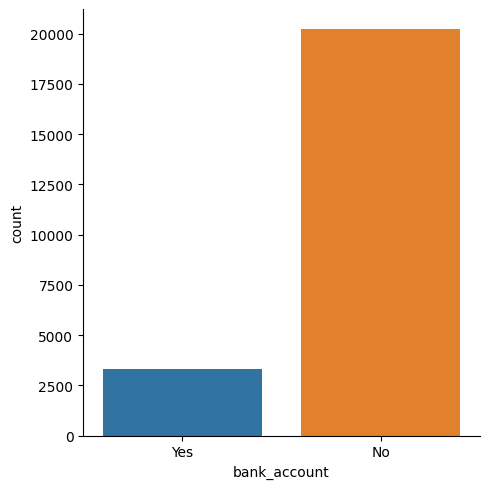

In [ ]:
#
sns.catplot(x="bank_account", kind="count", data=train)


This challenge is a classification problem since the target column have two variables. Yes and No. However we see that there is an imbalance between the two variables. This imbalance might lead to a low accuracy which might affect the model and the test results might not be very accurrate. We will look into it at a later step.

### Convert target label to numerical Data

Given the nature of this classification problem, it is advisable to transform the target column, representing the bank account status, into numerical values. Machine learning models are more effective when working with numerical data rather than categorical objects. Consequently, it is recommended to encode the labels as follows  **0 for No and 1 for Yes** . This conversion ensures compatibility with machine learning algorithms, enhancing their ability to analyze and learn from the data

In [ ]:

le = LabelEncoder()
train['bank_account'] = le.fit_transform(train['bank_account'])

 Split the target and feature columns

In [ ]:
# split the target column from the features column

X_train = train.drop(['bank_account'], axis=1)
y_train = train['bank_account']

In [ ]:

print("The features row and columns are:", X_train.shape)

X_train.head()

The features row and columns are: (23524, 12)


,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [ ]:

print("The target :", y_train.shape)

y_train.head()

The target : (23524,)


0    1
1    0
2    1
3    0
4    0
Name: bank_account, dtype: int64

### Data Preprocessing.

I will write a function that will do all the preprocessing

In [ ]:

# Transformation function

def wrangle(data):

   # Drop the "uniqueid" column as it is not needed for modeling. It will bring multicollinearilty and the feature will be big for the training
    data = data.drop(["uniqueid"], axis=1)

    # Seperate numeric features and categoricaal features
    numeric_features = data.select_dtypes("number").columns
    categorical_features = data.select_dtypes("object").columns

    # Pipeline for numeric feature transformation (MinMax Scaling
    numeric_transformer = Pipeline(
        steps=[("scaler", MinMaxScaler())] # The MinMaxScaler ensures that all numerical features have the same scale, \
                                            #preventing certain features from dominating others
    )

    categorical_transformer = Pipeline(
        steps=[
            ("encoder", OneHotEncoder(handle_unknown="ignore"))# one hot encoder changes the categorical data to numerical
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )

    preprocessed_data = preprocessor.fit_transform(data)

    return preprocessed_data




Apply the wrangle function to the training data

In [ ]:
Transformed_X_train =wrangle(X_train)

In [ ]:
# check the shape of the transformed training data
Transformed_X_train.shape

(23524, 40)

### Split train_data

Split the training data into two subsets for model training and validation. This division is accomplished using the train_test_split function from the sklearn.model_selection module. It will help us to see how the model is faring before introducing it to the test dataset

In [ ]:

from sklearn.model_selection import train_test_split

# X_Train, X_val, y_Train, y_val = train_test_split(X, y, test_size=0.2)
X_Train, X_val, y_Train, y_val = train_test_split(Transformed_X_train, y_train, stratify = y_train,
                                                  test_size = 0.1, random_state=42)

### Model Building and selection

In this step I use three models - Logisitic Regression Random Forest Classifier and Decision Tree Classifier.

After that I fit the training data on the models and evaluate the model on the validation set.

 I then do Accuracy Calculation and Reporting:

Then  do a Classification Report:-The classification report, including precision, recall, f1-score, and support, is printed for each model.
Confusion Matrix:

Confusion matrices are computed and plotted for each model, providing a visual representation of model performance.

The reason for using other metrics for evaluation is that accuracy score is not well suited for imbalanced datasets. Our data was imbalanced

Model: LogisticRegression, Accuracy Score: 0.8878
Classification Report for LogisticRegression:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2022
           1       0.70      0.35      0.47       331

    accuracy                           0.89      2353
   macro avg       0.80      0.66      0.70      2353
weighted avg       0.87      0.89      0.87      2353



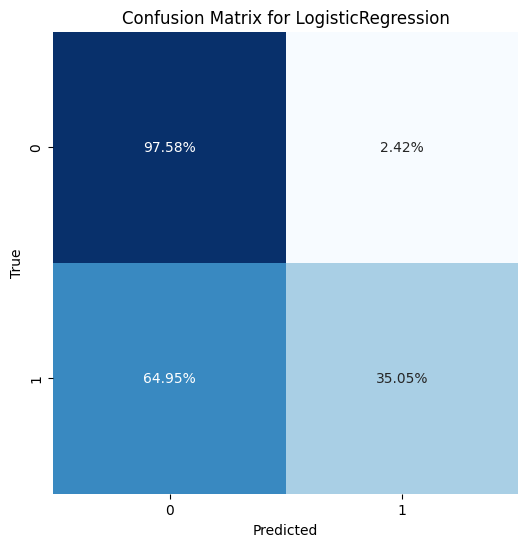

Model: RandomForestClassifier, Accuracy Score: 0.8598
Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      2022
           1       0.50      0.40      0.44       331

    accuracy                           0.86      2353
   macro avg       0.70      0.67      0.68      2353
weighted avg       0.85      0.86      0.85      2353



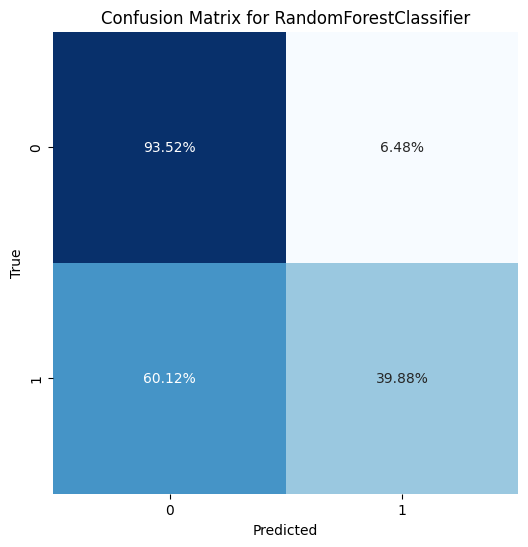

Model: DecisionTreeClassifier, Accuracy Score: 0.8394
Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      2022
           1       0.43      0.40      0.41       331

    accuracy                           0.84      2353
   macro avg       0.66      0.66      0.66      2353
weighted avg       0.84      0.84      0.84      2353



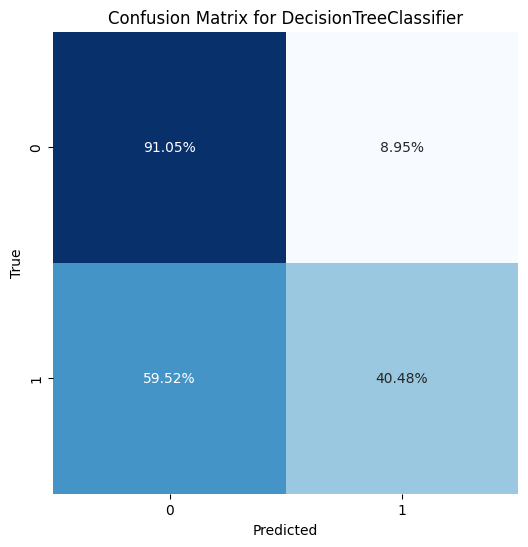

In [ ]:
# Model building and selection
lr = LogisticRegression()  #Instantiate Logistic Regression model
rc = RandomForestClassifier() #Instantiate Random Forest Classifier
dc = DecisionTreeClassifier() #Instantiate Decision Tree Classifier

models = [lr, rc, dc] # List of models to iterate over
accuracy = [] # List to store accuracy scores for each model
model_names = []  # List to store names of each model


# Loop through each model for training and evaluation
for model in models:
    model.fit(X_Train, y_Train) # Train the model on the training data

  # Evaluate the model on the validation set
    y_eval = model.predict(X_val)

   # Calculate and store the accuracy of the model
    accuracy.append(round(accuracy_score(y_val, y_eval), 4))
    model_names.append(type(model).__name__)
    print(f'Model: {type(model).__name__}, Accuracy Score: {round(accuracy_score(y_val, y_eval), 4)}')

    # Print classification report
    report = classification_report(y_val, y_eval)
    print(f'Classification Report for {type(model).__name__}:\n{report}')

# # Compute confusion matrix
    cm = confusion_matrix(y_val, y_eval,normalize='true')

    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False,
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {type(model).__name__}')
    plt.show()


There is a higher accuracy score on the three however
All models show a challenge in effectively predicting instances of the positive class (class 1).
Trade-offs between precision and recall highlight the difficulty in balancing the correct identification of positive instances with minimizing false positives.
Further model tuning or exploration of advanced techniques, such as hyperparameter tuning or ensemble methods, may be beneficial to improve overall model performance.

This could be maybe as a result of the imbalanced dataset

 Let me use a boosting classifier to see if there will be any change

The accuracy score is :  0.8920526986825329
Classification Report for XGB Classifier:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      2022
           1       0.70      0.41      0.52       331

    accuracy                           0.89      2353
   macro avg       0.80      0.69      0.73      2353
weighted avg       0.88      0.89      0.88      2353



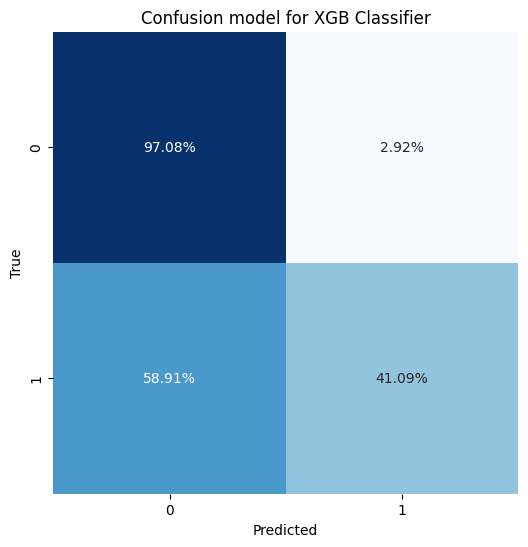

In [ ]:
# let me use a boosting classifier to see how it will perform
#import classifier algorithm here
from xgboost import XGBClassifier

# create models
xg_model = XGBClassifier()

#fitting the models
xg_model.fit(X_Train,y_Train)

# evaluate the model
xg_y_model = xg_model.predict(X_val)

# Get accuracy score
print("The accuracy score is : ", accuracy_score(y_val, xg_y_model))

# Print classification report
report = classification_report(y_val, xg_y_model)

print(f'Classification Report for XGB Classifier:\n{report}')
# # Compute confusion matrix
cm = confusion_matrix(y_val, xg_y_model,normalize='true')

    # Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False,
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion model for XGB Classifier')
plt.show()

The XGBoost Classifier has shown improvement over the previous models, especially in capturing instances of the positive class (class 1).
The higher accuracy and balanced performance metrics make it a promising candidate for this classification task.
Further analysis, parameter tuning, and consideration of business requirements would guide the final choice of the model.

Since the data was imbalanced we can see how it perfomed poorly in the classification report.  use SMOTE to balance the data

### Balancing the data using SMOTE

The accuracy score is :  0.721830550401979
              precision    recall  f1-score   support

           0       0.65      0.98      0.78      4035
           1       0.96      0.46      0.62      4050

    accuracy                           0.72      8085
   macro avg       0.80      0.72      0.70      8085
weighted avg       0.80      0.72      0.70      8085



Text(0.5, 1.0, 'Confusion model for XGB Classifier after applying smote')

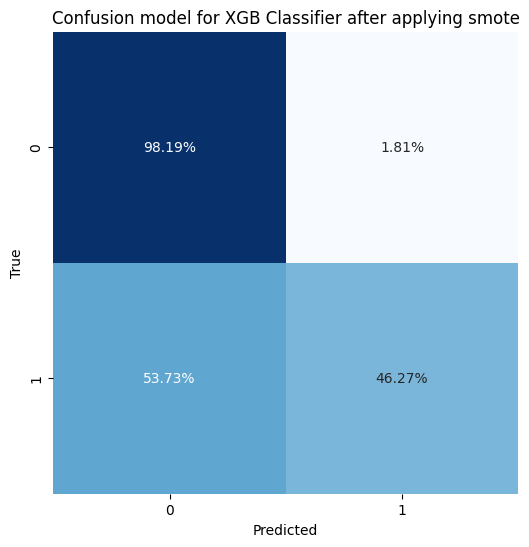

In [ ]:
# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(Transformed_X_train, y_train)

# Split the resampled data into training and validation sets
X_train_res, X_val_res, y_train_res, y_val_res = train_test_split(
    X_train_resampled, y_train_resampled, test_size=0.2, random_state=42
)


# create models using the XGB classifier
xg_model_1 = XGBClassifier()

#fitting the models
xg_model_1.fit(X_train_res,y_train_res)

# evaluate the model
xg_y_model_1 = xg_model.predict(X_val_res)

# accuracy score
print("The accuracy score is : ", accuracy_score(y_val_res, xg_y_model_1))

# Print classification report
report = classification_report(y_val_res, xg_y_model_1)

print(report)

# # Compute confusion matrix
cm = confusion_matrix(y_val_res, xg_y_model_1,normalize='true')

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False,
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion model for XGB Classifier after applying smote')

Comparison with Previous Models:

**Accuracy Improvement**: The accuracy has increased compared to previous models, which is expected when using SMOTE to address class imbalance.

**Class Imbalance Handling**: SMOTE has helped balance the precision and recall for both classes. The recall for class 1 has significantly improved, indicating a better ability to capture positive instances.

**Trade-off**: Despite the improvement, there are still trade-offs between precision and recall, particularly for class 0.


The use of SMOTE has addressed class imbalance and improved the model's ability to capture instances of the minority class (class 1).
Further analysis and fine-tuning, considering business requirements and the consequences of false positives and false negatives, may still be necessary to optimize model performance.

###  Lets try parameter tuning to see if there will be change.

We will use grid search cv

In [ ]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Optimize model parameters
# I run this code in google colab to make the execution much faster and use the best params in the next code
param_grid = {'min_child_weighth': [1, 5, 10],
        'gamma': [0.5, 1],
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3, 5]
        }
my_xgb_model = GridSearchCV(xg_model_1, param_grid,n_jobs=-1,verbose=2,cv=5)
my_xgb_model.fit(X_Train, y_Train)
print(my_xgb_model.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'gamma': 0.5, 'max_depth': 3, 'min_child_weighth': 1, 'subsample': 0.8}


The accuracy score for the fined tuned model is:  0.8863327149041434
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      4035
           1       0.92      0.85      0.88      4050

    accuracy                           0.89      8085
   macro avg       0.89      0.89      0.89      8085
weighted avg       0.89      0.89      0.89      8085



Text(0.5, 1.0, 'Confusion model for XGB Classifier after tuning')

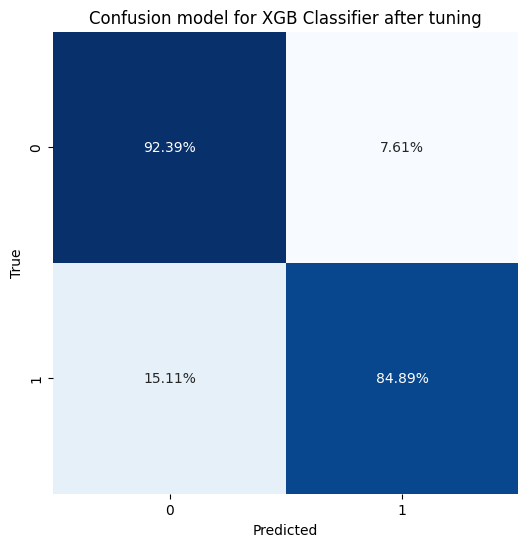

In [ ]:
# fit by setting best parameters and Evaluate model
# create models
xg_model_2 = XGBClassifier(min_child_weight=1, gamma=0.5, subsample=0.8, max_depth=3)

#fitting the models
xg_model_2.fit(X_train_res,y_train_res)

# evaluate the model
xg_y_model_2 = xg_model_2.predict(X_val_res)


# accuracy score
print("The accuracy score for the fined tuned model is: ", accuracy_score(y_val_res, xg_y_model_2))


# Print classification report
report = classification_report(y_val_res, xg_y_model_2)

print(report)

# # Compute confusion matrix
cm = confusion_matrix(y_val_res, xg_y_model_2,normalize='true')

    # Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False,
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion model for XGB Classifier after tuning')

Comparison with Previous Models:

There is an improvement after performing hyparameter tuning

**Accuracy Improvement**: The fine-tuned model with Grid Search CV has achieved a high accuracy, demonstrating effectiveness in classification.

**Balanced Metrics**: Precision, recall, and F1-score are balanced for both classes, indicating improved performance for both positive and negative instances.

O**ptimized Hyperparameters**: Grid Search CV likely helped in finding the best combination of hyperparameters for the model, leading to improved generalization.


The fine-tuned model with Grid Search CV has demonstrated improved accuracy and balanced performance metrics.
The balanced precision and recall for both classes suggest better overall model performance.
This model is a promising candidate for deployment,

## Working with the test test

In [ ]:
test.shape

(10086, 12)

In [ ]:
Transformed_test=wrangle(test)


In [ ]:
Transformed_test.shape

(10086, 40)

Use the model to make the prediction on the bank account

In [ ]:
# Get the predicted result for the test Data
test.bank_account = xg_model_2.predict(Transformed_test)

In [ ]:
# Create submission DataFrame
submitted_data = pd.DataFrame({"uniqueid": test["uniqueid"] + " x " + test["country"],
                           "bank_account": test.bank_account})

In [ ]:
submitted_data.head()

,uniqueid,bank_account
0,uniqueid_6056 x Kenya,1
1,uniqueid_6060 x Kenya,1
2,uniqueid_6065 x Kenya,0
3,uniqueid_6072 x Kenya,0
4,uniqueid_6073 x Kenya,0


In [ ]:
# Save the results in a csv file
submitted_data.to_csv('first_submission.csv', index = False)
files.download('first_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>